# Initiate APIs and modules

In [1]:
#!pip install psaw
#nltk.download('vader_lexicon')
#!pip install matplotlib==3.5.2

In [2]:
from psaw import PushshiftAPI
api = PushshiftAPI()

In [3]:
import pandas as pd
import datetime as dt
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

# Get submissions

In [4]:
def get_submissions(limit):
    
    #Get submissions using PSAW
    #limit (int): amount of submissions to be fetched
    
    #Fetch submissions
    submissions = list(api.search_submissions(subreddit="nft", limit=limit, 
                                              filter=["id", "title", "score", 
                                                      "upvote_ratio", "selftext", 
                                                      "is_self", "num_comments", 
                                                      "author", "url", "created_utc"]))
    
    #Create dataframe from submissions
    df = pd.DataFrame(submissions, columns=["author", "created", "id", "is_self",
                                            "num_comments", "score", "selftext", "title", 
                                            "upvote_ratio", "url", "created_utc", "d_"])
    
    #Drop unneccesary columns
    df = df.drop(columns=["created_utc", "d_"])
    #Convert UTC timestamp
    df["created"] = pd.to_datetime(df["created"], unit="s")
    
    #Save dataframe to CSV
    df.to_csv("submissions.csv", header=True, index=False)

    return (str(len(df)) + " submissions saved")

In [5]:
#get_submissions(100000)

In [6]:
submissions = pd.read_csv("submissions.csv", engine="python")
len(submissions)

99981

# Clean submissions

In [7]:
def clean_data(df):
    
    #Takes a dataframe (df) and cleans the data
    
    #Only include selfposts
    df = df.loc[(df["is_self"] == True)]
    #Remove NaN values from selftext
    df = df.dropna(subset=["selftext"])
    #Remove [deleted] and [removed] posts
    df = df.loc[(df["selftext"] != "[deleted]") & (df["selftext"] != "[removed]")]
    #Remove duplicates
    df = df.drop_duplicates(subset=["selftext"])
    #Remove new lines
    df = df.replace(r"\n", " ", regex = True)
    #Remove zero-width space character
    df = df.replace(r"&amp;#x200B;", "", regex = True)
    
    #Save dataframe to CSV
    df.to_csv("cleaned_submissions.csv", header=True, index=False)

    return (str(len(df)) + " submissions cleaned")

In [8]:
#clean_data(submissions)

In [9]:
cleaned_submissions = pd.read_csv("cleaned_submissions.csv", engine="python")
len(cleaned_submissions)

13346

# Sentiment analysis

In [10]:
#Initiate VADER
#https://github.com/cjhutto/vaderSentiment
SIA = SentimentIntensityAnalyzer()

In [11]:
def measure_sentiment(df):
    
    #Calculates VADER polarity scores for all selftext in a dataframe (df)
    
    #The compound score is computed by summing the valence scores of each word
    #in the lexicon, adjusted according to the rules, and then normalized to be
    #between -1 (most extreme negative) and +1 (most extreme positive).
    
    #The pos, neu, and neg scores are ratios for proportions of text that fall
    #in each category (these should all add up to be 1).
    
    #Create dictionary with lists for each attribute
    content = {"selftext":[],
               "compound":[],
               "neg":[],
               "neu":[],
               "pos":[]}
    
    #Loop over attribute rows and add sentiment scores to dictionary
    for row in df["selftext"]:
            #Skip None values
            if row:
                content["selftext"].append(row)
                #Calculate compound sentiment score (-1 to 1)
                content["compound"].append(SIA.polarity_scores(row)["compound"])
                #Calculate negative sentiment score (0 to 1)
                content["neg"].append(SIA.polarity_scores(row)["neg"])
                #Calculate neutral sentiment score (0 to 1)
                content["neu"].append(SIA.polarity_scores(row)["neu"])
                #Calculate positive sentiment score (0 to 1)
                content["pos"].append(SIA.polarity_scores(row)["pos"])
            else:
                continue
    
    #Create dataframe
    df = pd.DataFrame(content)
    
    #Remove 0.000 values
    df = df.loc[df["compound"] != 0.000]
    
    #Save dataframe to CSV
    df.to_csv("sentiment.csv", header=True, index=False)

    return (str(len(df)) + " submissions measured")

In [12]:
#measure_sentiment(cleaned_submissions)

## Resulting sentiment dataset

In [13]:
sentiment = pd.read_csv("sentiment.csv", engine="python")
sentiment

,selftext,compound,neg,neu,pos
0,Hey! I made this collection all alone and star...,0.3595,0.068,0.780,0.152
1,https://preview.redd.it/ea04j28l93q81.jpg?w...,0.9812,0.033,0.790,0.177
2,"""Miss #AxieInifinity⁉ Miss #MoBox⁉ Make sure y...",0.1391,0.134,0.710,0.156
3,⚡MOST ANTICIPATED GAMEFI IN 2022⚡ FaceBox.app ...,0.4939,0.000,0.894,0.106
4,The Crypto Animal Farmer's Club NFTs are LIVE!...,0.5707,0.000,0.885,0.115
...,...,...,...,...,...
9055,A project that's minting today wants me to put...,0.4696,0.000,0.925,0.075
9056,"With OpenSea going down, I started thinking ab...",0.9437,0.000,0.711,0.289
9057,This is my first ever ntf. ı created this piec...,0.8225,0.000,0.775,0.225
9058,I’m having a idea in mind that I would like to...,0.9524,0.000,0.731,0.269


In [14]:
sentiment.describe()

,compound,neg,neu,pos
count,9060.000000,9060.000000,9060.000000,9060.000000
mean,0.549816,0.035358,0.800500,0.164143
std,0.461253,0.063513,0.105237,0.106162
min,-0.991300,0.000000,0.000000,0.000000
25%,0.381800,0.000000,0.748000,0.094000
50%,0.705900,0.000000,0.817000,0.148000
75%,0.898600,0.050000,0.873000,0.216000
max,0.999400,1.000000,0.983000,1.000000


## Boxplots

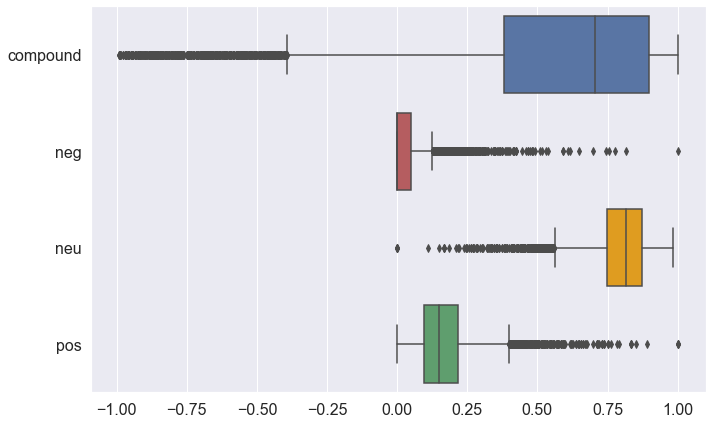

In [15]:
plt.figure(figsize=(10,6))
box = pd.DataFrame(data = sentiment, columns = ["compound", "neg", "neu", "pos"])
colors = {"compound":"b", "neg": "r", "neu":"orange", "pos":"g"}
sns.boxplot(data=box, palette=colors, orient="h")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("boxplot.png", bbox_inches="tight", dpi=300)
plt.show()

# Sentiment distributions

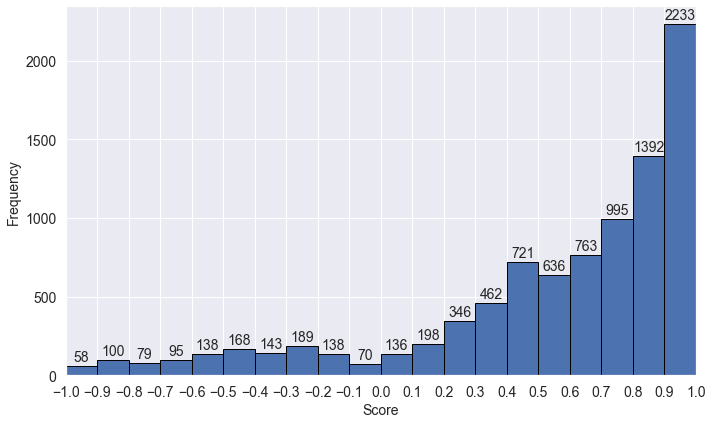

In [16]:
#Compound sentiment distribution
plt.figure(figsize=(10,6))
bins = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
graph = plt.hist(sentiment["compound"], bins=bins, ec="black")
    
#Set bar labels
for i in range(len(bins)-1):
    plt.text(graph[1][i] + 0.05, graph[0][i] + 30, str(int(graph[0][i])), ha="center", fontsize=14)

#Configure and show plot
plt.xlim(-1,1)
plt.xticks(bins)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("compound.png", bbox_inches="tight", dpi=300)
plt.show()

In [46]:
print("Negative:", sentiment[(sentiment["compound"] < -0.05)]["compound"].count())
print("Neutral:", sentiment[(sentiment["compound"] > -0.05) & (sentiment["compound"] < 0.05)]["compound"].count())
print("Positive:", sentiment[(sentiment["compound"] > 0.05)]["compound"].count())

Negative: 1153
Neutral: 67
Positive: 7840


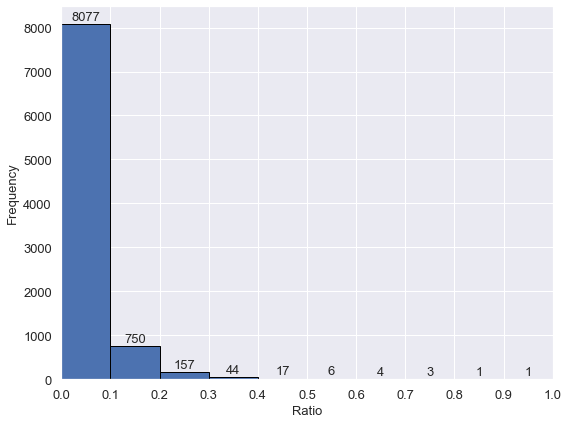

In [17]:
#Negative sentiment distribution
plt.figure(figsize=(8,6))
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
graph = plt.hist(sentiment["neg"], bins=bins, ec="black")
    
#Set bar labels
for i in range(len(bins)-1):
    plt.text(graph[1][i] + 0.05, graph[0][i] + 100, str(int(graph[0][i])), ha="center", fontsize=13)

#Configure and show plot
plt.xlim(0,1)
plt.xticks(bins)
plt.xlabel("Ratio", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

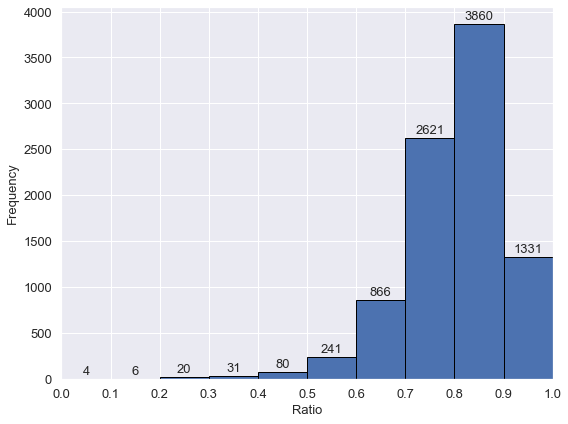

In [18]:
#Neutral sentiment distribution
plt.figure(figsize=(8,6))
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
graph = plt.hist(sentiment["neu"], bins=bins, ec="black")
    
#Set bar labels
for i in range(len(bins)-1):
    plt.text(graph[1][i] + 0.05, graph[0][i] + 50, str(int(graph[0][i])), ha="center", fontsize=13)

#Configure and show plot
plt.xlim(0,1)
plt.xticks(bins)
plt.xlabel("Ratio", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

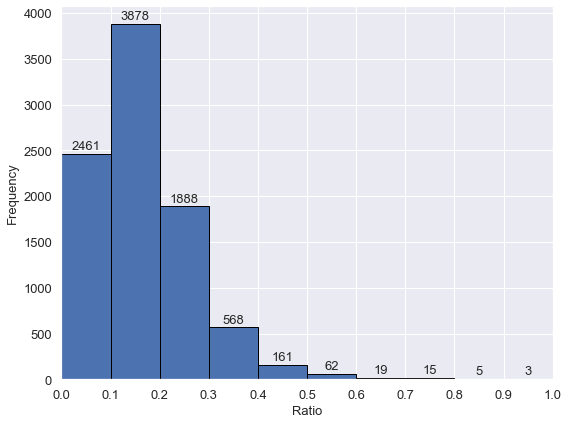

In [19]:
#Positive sentiment distribution
plt.figure(figsize=(8,6))
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
graph = plt.hist(sentiment["pos"], bins=bins, ec="black")
    
#Set bar labels
for i in range(len(bins)-1):
    plt.text(graph[1][i] + 0.05, graph[0][i] + 50, str(int(graph[0][i])), ha="center", fontsize=13)

#Configure and show plot
plt.xlim(0,1)
plt.xticks(bins)
plt.xlabel("Ratio", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

# Qualitative approach

## Splitting sentiment dataset into quartiles

In [20]:
#Sort sentiment by compound score (ascending)
#sorted_sentiment = sentiment.sort_values(by="compound", ascending=True)

#Split sorted sentiment into quartiles
#q1, q2, q3, q4 = np.split(sorted_sentiment, [int(0.25*len(sorted_sentiment)), int(0.5*len(sorted_sentiment)), int(0.75*len(sorted_sentiment))])

## Most negative quartile (q1)

In [21]:
#Save quartile to CSV file
#q1.to_csv("q1.csv", header=True, index=False)

q1 = pd.read_csv("q1.csv", engine="python")
q1

,selftext,compound,neg,neu,pos
0,""" I don’t know if this is just the result of ...",-0.9913,0.223,0.754,0.023
1,For context I've personally invested around 5k...,-0.9900,0.160,0.755,0.085
2,You are hurting the environment with NFTs. NFT...,-0.9897,0.383,0.603,0.013
3,**The aim of all my collection is to evoke yo...,-0.9888,0.179,0.711,0.110
4,NFTs Released 14/02/2022 sold with SOL - the S...,-0.9883,0.114,0.848,0.037
...,...,...,...,...,...
2260,Don't know how to promote and sell your nft? c...,0.3818,0.000,0.833,0.167
2261,I'm a NFT noob. Can NFT be added to any wallet...,0.3818,0.037,0.844,0.119
2262,Lazy Tiger Wood Club release in 20 minutes 🚀🚀🚀...,0.3818,0.094,0.752,0.154
2263,"Hey, I’m 25M Brazilian, living in Canada for 4...",0.3818,0.033,0.873,0.094


In [22]:
q1.describe()

,compound,neg,neu,pos
count,2265.000000,2265.000000,2265.000000,2265.000000
mean,-0.118418,0.091845,0.824874,0.083281
std,0.401117,0.097901,0.114183,0.083635
min,-0.991300,0.000000,0.000000,0.000000
25%,-0.440400,0.000000,0.769000,0.028000
50%,-0.064400,0.075000,0.849000,0.071000
75%,0.264000,0.133000,0.907000,0.115000
max,0.381800,1.000000,0.983000,1.000000


## Middle quartiles (q2 and q3)

In [23]:
#q2.to_csv("q2.csv", header=True, index=False)

q2 = pd.read_csv("q2.csv", engine="python")
q2

,selftext,compound,neg,neu,pos
0,Besides making carbon credit accessible via ...,0.3818,0.000,0.909,0.091
1,"Hey everyone, So I am wanting to get into, wr...",0.3818,0.052,0.849,0.100
2,Only 69 total units. Stealth mint live at: [ht...,0.3818,0.036,0.856,0.108
3,"Hello everybody, I am a shitfluencer since 24 ...",0.3818,0.000,0.952,0.048
4,Why are some people thinking that GameStop Mar...,0.3818,0.000,0.902,0.098
...,...,...,...,...,...
2260,Have you had any disappointment this year rega...,0.7053,0.093,0.649,0.258
2261,Limited number of NFT's available featuring be...,0.7054,0.055,0.721,0.224
2262,AYO AN NFT PROJECT 100% PINOY MADE. MESSAGE M...,0.7057,0.000,0.764,0.236
2263,Our goal is to create digital NFT assets used ...,0.7059,0.000,0.879,0.121


In [24]:
q2.describe()

,compound,neg,neu,pos
count,2265.000000,2265.000000,2265.000000,2265.000000
mean,0.553628,0.016968,0.817479,0.165553
std,0.095787,0.032725,0.115211,0.110996
min,0.381800,0.000000,0.000000,0.023000
25%,0.469600,0.000000,0.770000,0.096000
50%,0.557400,0.000000,0.847000,0.133000
75%,0.636900,0.023000,0.893000,0.198000
max,0.705900,0.179000,0.977000,1.000000


In [25]:
#q3.to_csv("q3.csv", header=True, index=False)

q3 = pd.read_csv("q3.csv", engine="python")
q3

,selftext,compound,neg,neu,pos
0,Just want to share it with you guys this upco...,0.7059,0.000,0.785,0.215
1,Can yall help me blow this tweet up only need...,0.7059,0.000,0.652,0.348
2,selling +18 nft ( xxxpage exclusive access) ...,0.7065,0.000,0.832,0.168
3,"Hi collectors , today I buyed several nft's fo...",0.7066,0.000,0.906,0.094
4,🚀 🚀 We are happy to inform you about the mi...,0.7067,0.000,0.787,0.213
...,...,...,...,...,...
2260,"What’s up everyone? I’m new to NFTs, and this ...",0.8983,0.052,0.752,0.197
2261,"Hey everyone, I've recently created a few of t...",0.8983,0.000,0.716,0.284
2262,I am slowly uploading the best pictures I was ...,0.8985,0.000,0.694,0.306
2263,Welcome to OG RICH NFT COLLECTION THE FUTUR GA...,0.8986,0.000,0.733,0.267


In [26]:
q3.describe()

,compound,neg,neu,pos
count,2265.000000,2265.000000,2265.000000,2265.000000
mean,0.812268,0.015716,0.786158,0.198125
std,0.056075,0.026972,0.099743,0.098575
min,0.705900,0.000000,0.109000,0.037000
25%,0.765000,0.000000,0.739000,0.130000
50%,0.821300,0.000000,0.802000,0.178000
75%,0.860300,0.028000,0.855000,0.241000
max,0.898600,0.217000,0.963000,0.891000


## Most positive quartile (q4)

In [27]:
#Save quartile to CSV file
#q4.to_csv("q4.csv", header=True, index=False)

q4 = pd.read_csv("q4.csv", engine="python")
q4

,selftext,compound,neg,neu,pos
0,Hey guys what's up? I have a question for you....,0.8986,0.030,0.854,0.115
1,https://preview.redd.it/4labyr45ati81.jpg?...,0.8986,0.000,0.677,0.323
2,[www.starryape.com](https://www.starryape.com)...,0.8986,0.000,0.677,0.323
3,World Eternal Online [@WorldEternalMMO](ht...,0.8986,0.000,0.452,0.548
4,"Hey guys, I'm officially joining the NFT comm...",0.8987,0.033,0.834,0.134
...,...,...,...,...,...
2260,"Hello there fellow crypto artists, would love ...",0.9990,0.000,0.834,0.166
2261,Hi all! In this thread I will share my experie...,0.9990,0.063,0.719,0.217
2262,Hello Reddit community! As you could already ...,0.9992,0.044,0.789,0.167
2263,I always find it funny that people are so quic...,0.9993,0.025,0.807,0.168


In [28]:
q4.describe()

,compound,neg,neu,pos
count,2265.000000,2265.000000,2265.000000,2265.000000
mean,0.951785,0.016902,0.773489,0.209614
std,0.027853,0.022369,0.078964,0.079355
min,0.898600,0.000000,0.451000,0.051000
25%,0.929200,0.000000,0.729000,0.152000
50%,0.953400,0.007000,0.785000,0.196000
75%,0.975700,0.028000,0.830000,0.253000
max,0.999400,0.131000,0.949000,0.549000


## Random sample (5%) of most negative quartile (q1)

In [29]:
#Random sample of most negative quartile (5%)
#q1s = q1.sample(frac=0.05)

#Save random sample to CSV file
#q1s.to_csv("q1s.csv", header=True, index=False)

q1s = pd.read_csv("q1s.csv", engine="python")
q1s

#Save random sample to Excel file
#q1s.to_excel("q1s_excel.xls", header=True, index=False)

,selftext,compound,neg,neu,pos
0,I don't think anyone is doing this kind of art...,0.2023,0.076,0.833,0.091
1,Im selling the web domain [https://crypto.phot...,0.2263,0.000,0.872,0.128
2,Any resale price predictions on the adidas int...,-0.2732,0.160,0.840,0.000
3,8888 NFTs Designers from LV and Warner Bros ...,0.3595,0.000,0.858,0.142
4,It’s the Athletic Tiger Club. It has plans for...,-0.3950,0.113,0.887,0.000
...,...,...,...,...,...
108,I understand the idea. But I’m having trouble ...,-0.1680,0.060,0.890,0.050
109,https://i.imgur.com/GhbyqAJ.jpg Ether or Tail...,-0.3382,0.047,0.953,0.000
110,This guy wants to donate 30% of the nft sales ...,-0.2924,0.146,0.752,0.102
111,Full video: [https://youtu.be/6M6ybQhY3UQ](htt...,-0.7059,0.103,0.866,0.031


In [30]:
q1s.describe()

,compound,neg,neu,pos
count,113.000000,113.000000,113.000000,113.000000
mean,-0.153796,0.090805,0.831823,0.077372
std,0.403970,0.085987,0.097190,0.062317
min,-0.945100,0.000000,0.437000,0.000000
25%,-0.461700,0.000000,0.783000,0.034000
50%,-0.168000,0.080000,0.850000,0.073000
75%,0.222800,0.136000,0.893000,0.110000
max,0.380200,0.467000,0.979000,0.333000


## Random sample (5%) of most positive quartile (q4)

In [31]:
#Random sample of most positive quartile (5%)
#q4s = q4.sample(frac=0.05)

#Save random sample to CSV file
#q4s.to_csv("q4s.csv", header=True, index=False)

q4s = pd.read_csv("q4s.csv", engine="python")
q4s

#Save random sample to Excel file
#q4s.to_excel("q4s_excel.xls", header=True, index=False)

,selftext,compound,neg,neu,pos
0,"Hello, my friend! I have lovingly created a c...",0.9838,0.000,0.575,0.425
1,https://preview.redd.it/ufddug4aetk81.png?widt...,0.9049,0.032,0.866,0.103
2,"Hello, I have a photo collection and I wanted ...",0.9535,0.037,0.787,0.176
3,[https://opensea.io/collection/pixel-weapons-f...,0.9001,0.000,0.778,0.222
4,I been in a funk lately and this piece really ...,0.9382,0.000,0.609,0.391
...,...,...,...,...,...
108,💎Welcome anyone who would like to participate ...,0.9759,0.032,0.734,0.234
109,"Hello everyone, I recently became passion...",0.9708,0.021,0.713,0.266
110,"I know a lot of you here, despite the fact tha...",0.9452,0.093,0.756,0.151
111,Hello everyone.....I'm a young orthopedic surg...,0.9905,0.007,0.816,0.177


In [32]:
q4s.describe()

,compound,neg,neu,pos
count,113.000000,113.000000,113.000000,113.000000
mean,0.953592,0.016142,0.773434,0.210407
std,0.028471,0.021133,0.084556,0.086403
min,0.898600,0.000000,0.485000,0.051000
25%,0.930900,0.000000,0.734000,0.148000
50%,0.961500,0.008000,0.784000,0.199000
75%,0.974200,0.027000,0.832000,0.242000
max,0.995800,0.110000,0.949000,0.515000
